In [2]:
# script to save the rankings for the mechanism
import os
import re
import sys
import glob
import copy
import yaml
import pickle
import subprocess
import numpy as np
import pandas as pd

import rmgpy.data.kinetics
import rmgpy.chemkin
import cantera as ct

import matplotlib.colors as mcolors
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


sys.path.append('/home/moon/autoscience/reaction_calculator/database/')
import importlib
import database_fun


In [3]:
# Load the experimental conditions
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm

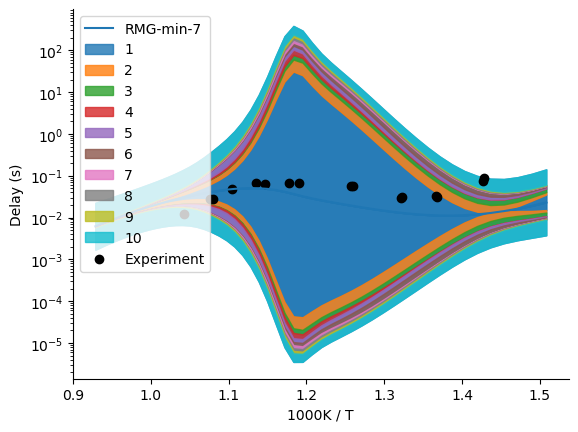

In [96]:
mech_dir = '/home/moon/autoscience/fuels/butane_20240501'

start_color = (1.0, 0.8, 0.0)
end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
labels = ['RMG-min-1', 'RMG-min-7']
alphas = [0.7, 0.5]
alpha = 0.8
linestyles = ['solid', 'dashed']


# Load the analysis files
analysis_dir = os.path.join(mech_dir, 'analysis')
total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)
with open(os.path.join(mech_dir, 'ct2rmg_rxn.pickle'), 'rb') as f:
    ct2rmg_rxn = pickle.load(f)

delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
sensitivity_squared = np.float_power(first_derivative, 2.0)
improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
avg_improvement_score = np.nanmean(improvement_score, axis=1)
avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
improvement_score[np.isnan(improvement_score)] = -np.inf
total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()



# fetch the Table 7 results
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51
temperatures = np.linspace(Tmin, Tmax, K)

table_index = 7


base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)
plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alpha, color=colors[0])
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alpha, color=colors[0])



# get the plotting order
uncertainty_7_squared = np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0))[:, (table_index - 1) * K: table_index * K]
total_uncertainty_7_squared = np.nansum(uncertainty_7_squared, axis=0)

u_2 = uncertainty_7_squared[:, 20]
indices = np.arange(len(u_2))
param_order = [x for _, x in sorted(zip(u_2, indices))][::-1]
# for i in range(0, 10):
#     print(i, u_2[param_order[i]])


M = 10  # how many components to draw
# get the lumped uncertainties
lumped_uncertainty_7_squared = np.zeros((M, K))
lumped_uncertainty_percentages = np.zeros((M, K))
for i in range(M - 1):
    lumped_uncertainty_7_squared[i, :] = uncertainty_7_squared[param_order[i], :]
    lumped_uncertainty_percentages[i, :] = np.divide(lumped_uncertainty_7_squared[i, :], total_uncertainty_7_squared)
    uncertainty_7_squared[param_order[i], :] = np.zeros(K)
lumped_uncertainty_7_squared[-1, :] = np.nansum(uncertainty_7_squared, axis=0)
lumped_uncertainty_percentages[-1, :] = np.divide(lumped_uncertainty_7_squared[-1, :], total_uncertainty_7_squared)



total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])



# plot the first mech and uncertainty
plt.plot(1000.0 / temperatures, base_delays7, color=colors[0], label='RMG-min-7')


upward_bounds = np.zeros((M + 1, K))
downward_bounds = np.zeros((M + 1, K))
upward_bounds[0, :] = base_delays7
downward_bounds[0, :] = base_delays7
for i in range(1, M):
    upward_bounds[i, :] = np.exp(np.log(base_delays7) + np.multiply(np.sum(lumped_uncertainty_percentages[:i, :], axis=0), total_uncertainty7))
    downward_bounds[i, :] = np.exp(np.log(base_delays7) - np.multiply(np.sum(lumped_uncertainty_percentages[:i, :], axis=0), total_uncertainty7))
    plt.fill_between(1000.0 / temperatures, upward_bounds[i - 1, :], upward_bounds[i, :], alpha=alpha, color=colors[(i - 1) % len(colors)], label=str(i))
    plt.fill_between(1000.0 / temperatures, downward_bounds[i, :], downward_bounds[i - 1, :], alpha=alpha, color=colors[(i - 1) % len(colors)])

# fill in everything else
plt.fill_between(1000.0 / temperatures, upward_bounds[M - 1, :], upper_bound_stddev, alpha=alpha, color=colors[(M - 1)%len(colors)], label=str(M))
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, downward_bounds[M - 1, :], alpha=alpha, color=colors[(M - 1)%len(colors)])

    
    
# upper_bound_stddev = np.exp(np.log(base_delays7) + np.multiply(lumped_uncertainty_percentages[0, :], total_uncertainty7))
# lower_bound_stddev = np.exp(np.log(base_delays7) - np.multiply(lumped_uncertainty_percentages[0, :], total_uncertainty7))

# upper_bound_stddev2 = np.exp(np.log(base_delays7) + 
#                              np.multiply(lumped_uncertainty_percentages[0, :], total_uncertainty7) +
#                              np.multiply(lumped_uncertainty_percentages[1, :], total_uncertainty7))
# lower_bound_stddev2 = np.exp(np.log(base_delays7) -
#                              np.multiply(lumped_uncertainty_percentages[0, :], total_uncertainty7) -
#                              np.multiply(lumped_uncertainty_percentages[1, :], total_uncertainty7)
#                             )



# Local Uncertainty

# plt.fill_between(1000.0 / temperatures, upper_bound_stddev, upper_bound_stddev2, alpha=alpha, color=colors[1])
# plt.fill_between(1000.0 / temperatures, lower_bound_stddev2, lower_bound_stddev, alpha=alpha, color=colors[1])



plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')


ax = plt.gca()
ax.set_yscale('log')


plt.legend()
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
    


In [42]:
lower_bound_stddev2

array([0.02015635, 0.01579875, 0.01251421, 0.0100881 , 0.00840159,
       0.00731392, 0.0066683 , 0.00633303, 0.00621926, 0.00627572,
       0.00647555, 0.00680852, 0.00726467, 0.00784277, 0.00854137,
       0.00935726, 0.01028279, 0.01130114, 0.01238071, 0.01347337,
       0.01460049, 0.01618469, 0.01896993, 0.02281307, 0.02669887,
       0.0299965 , 0.0324686 , 0.03405066, 0.03479072, 0.03480734,
       0.0342366 , 0.03319808, 0.03178741, 0.0301143 , 0.02831857,
       0.02650172, 0.02469311, 0.02290396, 0.02114455, 0.01942671,
       0.01776362, 0.01616838, 0.01465269, 0.01322588, 0.01189441,
       0.0106619 , 0.0095293 , 0.00849531, 0.0075568 , 0.00670932,
       0.00594745])

In [14]:
np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)).shape

(2020, 612)

In [ ]:
# do the contribution as a percent

In [11]:
temperatures[20]

828.6

0 53.33667711612553
1 5.830603018941365
2 2.0619552373681658
3 1.976700379440086
4 1.8841361207487113
5 1.7005169308025865
6 1.2113916263384823
7 1.1530531839981013
8 0.954897219014124
9 0.7683174579257867


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice


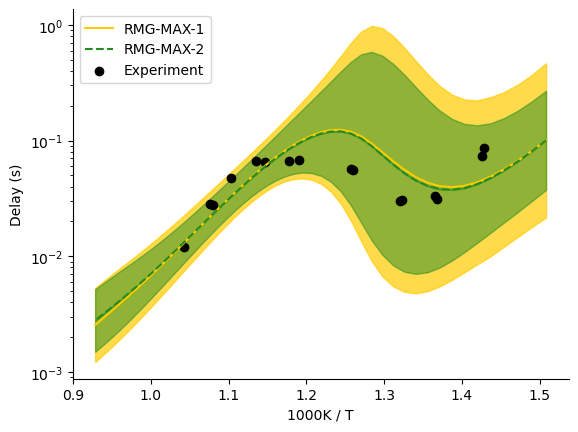

In [11]:
# Repeat for RMG-MAX
mech_dirs = [
    '/home/moon/autoscience/fuels/with_lib/butane_20240401',
    '/home/moon/autoscience/fuels/with_lib/butane_20240413',
]

start_color = (1.0, 0.8, 0.0)
end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
colors = [start_color, end_color]
labels = ['RMG-MAX-1', 'RMG-MAX-2']
alphas = [0.7, 0.5]
linestyles = ['solid', 'dashed']

for m, mech_dir in enumerate(mech_dirs):
    # Load the analysis files
    analysis_dir = os.path.join(mech_dir, 'analysis')
    total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
    dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
    first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
    improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
    base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
    base_delays = np.load(base_delay_file)
    
    delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
    sensitivity_squared = np.float_power(first_derivative, 2.0)
    improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
    avg_improvement_score = np.nanmean(improvement_score, axis=1)
    avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
    improvement_score[np.isnan(improvement_score)] = -np.inf
    total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
    total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

    
    # fetch the Table 7 results
    Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
    Tmin = 663
    K = 51
    temperatures = np.linspace(Tmin, Tmax, K)

    table_index = 7


    base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
    total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])

    upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
    lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)

    # plot the first mech and uncertainty
    plt.plot(1000.0 / temperatures, base_delays7, color=colors[m], label=labels[m], linestyle=linestyles[m])


    # Local Uncertainty
    plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alphas[m], color=colors[m])
    plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alphas[m], color=colors[m])



plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='Experiment')


ax = plt.gca()
ax.set_yscale('log')


plt.legend()
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')
plt.legend(loc='upper left')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
    
